<a href="https://colab.research.google.com/github/ZyLiao-0011/NX414/blob/main/data_driven_mobilnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.nn import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW

from tqdm import tqdm
import numpy as np
import pandas as pd
import h5py
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import sys
sys.path.append('/content/drive/MyDrive/nx414')
from utils import load_it_data, visualize_img

In [6]:
path_to_data = '/content/drive/MyDrive/nx414' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [7]:
class SpikeData(Dataset):
    def __init__(self,stimulus,spike = None):
        self.stimulus = torch.tensor(stimulus)

        if spike is not None:
          self.spike = torch.tensor(spike)
          self.num_neuron = self.spike.shape[1]
        else:
          self.spike = None
          self.num_neuron = None

    def __len__(self):
        return len(self.stimulus)

    def __getitem__(self, idx):
        if self.spike is not None:
            return self.stimulus[idx], self.spike[idx]
        else:
            return self.stimulus[idx]

In [8]:
ITdataloader_train = DataLoader(SpikeData(stimulus_train, spikes_train), batch_size=64, shuffle=True)
ITdataloader_val = DataLoader(SpikeData(stimulus_val, spikes_val), batch_size=64, shuffle=False)
ITdataloader_test = DataLoader(SpikeData(stimulus_test,spike = None), batch_size=64, shuffle=False)

In [ ]:
class ShallowCNN(nn.Module):
    def __init__(self,num_neuron):
        super(ShallowCNN, self).__init__()

        # Conv block 1
        self.convblock1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(16),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        # Conv block 2
        self.convblock2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(32),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        # Conv block 3
        self.convblock3 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        # Adaptive flatten to work for 224x224 input images
        self.flatten = nn.Flatten()

        # Calculate the size of the feature map after conv blocks
        # For 224x224 input -> 112 -> 56 -> 28 after 3 maxpools
        conv_output_size = 64 * (224 // 8) * (224 // 8)  # 64 channels, 28x28 feature map

        self.fc1 = nn.Linear(conv_output_size, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_neuron)  # Output = num_neuron = 168


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    @staticmethod # defines that the following function does not take self as input
    @torch.no_grad() # ensures that following function runs without tracking gradients
    # making the initialisation faster and more memory-efficient. The parameters remain trainable.
    def init_weights(module):
        # YOUR CODE HERE
        # raise NotImplementedError()

        # He initialization
        # Conv2d layers
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        # Linear layers
        elif isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            nn.init.zeros_(module.bias)

        # Initialize BatchNorm weights to 1 and bias to 0
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)

In [ ]:
class ShallowCNN2(nn.Module):
    def __init__(self,num_neuron):
        super(ShallowCNN2, self).__init__()

        # Conv block 1
        self.convblock1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(16),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        # Conv block 2
        self.convblock2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(32),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        # Conv block 3
        self.convblock3 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        self.convblock4 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        # Adaptive flatten to work for 224x224 input images
        self.flatten = nn.Flatten()

        # Calculate the size of the feature map after conv blocks
        # For 224x224 input -> 112 -> 56 -> 28 after 3 maxpools
        conv_output_size = 128 * (224 // 16) * (224 // 16)  # 64 channels, 28x28 feature map

        self.fc1 = nn.Linear(conv_output_size, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_neuron)  # Output = num_neuron = 168


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    @staticmethod # defines that the following function does not take self as input
    @torch.no_grad() # ensures that following function runs without tracking gradients
    # making the initialisation faster and more memory-efficient. The parameters remain trainable.
    def init_weights(module):
        # YOUR CODE HERE
        # raise NotImplementedError()

        # He initialization
        # Conv2d layers
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        # Linear layers
        elif isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            nn.init.zeros_(module.bias)

        # Initialize BatchNorm weights to 1 and bias to 0
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)

In [9]:
class MobilnetStudent(nn.Module):
    def __init__(self, num_neuron):
        super(MobilnetStudent, self).__init__()
        self.model = nn.Sequential(
            # Initial Convolutional Block 1
            nn.Conv2d(3, 8, kernel_size=3, stride=2, padding=1, bias=False),  # Downsample early
            nn.BatchNorm2d(8),
            nn.ReLU6(inplace=True),

            # Convolutional Block 2
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU6(inplace=True),

            # Convolutional Block 3
            nn.Conv2d(16, 24, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(24),

            # Inverted Residual Block (lightweight)
            nn.Conv2d(24, 48, kernel_size=1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU6(inplace=True),
            nn.Conv2d(48, 48, kernel_size=3, stride=1, padding=1, groups=48, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU6(inplace=True),
            nn.Conv2d(48, 24, kernel_size=1, bias=False),
            nn.BatchNorm2d(24),

            # Downsampling block
            nn.Conv2d(24, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True),

            # Final Block
            nn.Conv2d(32, 32, kernel_size=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True),

            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Dropout(0.2),
            nn.Flatten(),
            nn.Linear(32 * 1 * 1, num_neuron)
        )

    def forward(self, x):
        out = self.model(x)
        return out

    @staticmethod # defines that the following function does not take self as input
    @torch.no_grad() # ensures that following function runs without tracking gradients
    # making the initialisation faster and more memory-efficient. The parameters remain trainable.
    def init_weights(module):
        # YOUR CODE HERE
        # raise NotImplementedError()

        # He initialization
        # Conv2d layers
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        # Linear layers
        elif isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            nn.init.zeros_(module.bias)

        # Initialize BatchNorm weights to 1 and bias to 0
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)

In [11]:
import copy

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=2, scheduler=None):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
            for stimulus, spikes in train_loader:
                stimulus, spikes = stimulus.to(device), spikes.to(device)
                optimizer.zero_grad()

                outputs = model(stimulus)
                loss = criterion(outputs, spikes)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                pbar.set_postfix(loss=running_loss / (pbar.n + 1))
                pbar.update(1)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for stimulus, labels in val_loader:
                stimulus, labels = stimulus.to(device), labels.to(device)
                outputs = model(stimulus)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        if scheduler:
            scheduler.step(val_loss)

        torch.cuda.empty_cache()

    model.load_state_dict(best_model_wts)

    return model

In [20]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
loss_fn = nn.MSELoss()
#model = ShallowCNN2(num_neuron=168)
#model.apply(ShallowCNN2.init_weights)
model = MobilnetStudent(num_neuron=168)
model.apply(MobilnetStudent.init_weights)
model.to(device)

optimizer = AdamW(model.parameters(), lr=0.005, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=5)
train_model(model, ITdataloader_train, ITdataloader_val, loss_fn, optimizer, num_epochs=200, scheduler=scheduler)

save_path = '/content/drive/MyDrive/nx414/MobilnetStudent.pth'
torch.save(model.state_dict(), save_path)

Epoch 1/200: 100%|██████████| 41/41 [00:01<00:00, 30.41it/s, loss=0.143]


Epoch [1/200], Train Loss: 0.1426
Validation Loss: 0.1394


Epoch 2/200: 100%|██████████| 41/41 [00:01<00:00, 32.02it/s, loss=0.134]


Epoch [2/200], Train Loss: 0.1342
Validation Loss: 0.1440


Epoch 3/200: 100%|██████████| 41/41 [00:01<00:00, 31.56it/s, loss=0.132]


Epoch [3/200], Train Loss: 0.1316
Validation Loss: 0.1349


Epoch 4/200: 100%|██████████| 41/41 [00:01<00:00, 31.28it/s, loss=0.129]


Epoch [4/200], Train Loss: 0.1290
Validation Loss: 0.2303


Epoch 5/200: 100%|██████████| 41/41 [00:01<00:00, 31.52it/s, loss=0.128]


Epoch [5/200], Train Loss: 0.1280
Validation Loss: 0.1331


Epoch 6/200: 100%|██████████| 41/41 [00:01<00:00, 31.68it/s, loss=0.126]


Epoch [6/200], Train Loss: 0.1265
Validation Loss: 0.1313


Epoch 7/200: 100%|██████████| 41/41 [00:01<00:00, 31.72it/s, loss=0.125]


Epoch [7/200], Train Loss: 0.1251
Validation Loss: 0.1341


Epoch 8/200: 100%|██████████| 41/41 [00:01<00:00, 31.98it/s, loss=0.124]


Epoch [8/200], Train Loss: 0.1240
Validation Loss: 0.1298


Epoch 9/200: 100%|██████████| 41/41 [00:01<00:00, 31.34it/s, loss=0.123]


Epoch [9/200], Train Loss: 0.1229
Validation Loss: 0.1418


Epoch 10/200: 100%|██████████| 41/41 [00:01<00:00, 31.17it/s, loss=0.122]


Epoch [10/200], Train Loss: 0.1217
Validation Loss: 0.1237


Epoch 11/200: 100%|██████████| 41/41 [00:01<00:00, 31.38it/s, loss=0.12]


Epoch [11/200], Train Loss: 0.1198
Validation Loss: 0.1251


Epoch 12/200: 100%|██████████| 41/41 [00:01<00:00, 31.31it/s, loss=0.119]


Epoch [12/200], Train Loss: 0.1188
Validation Loss: 0.1240


Epoch 13/200: 100%|██████████| 41/41 [00:01<00:00, 31.53it/s, loss=0.118]


Epoch [13/200], Train Loss: 0.1178
Validation Loss: 0.1243


Epoch 14/200: 100%|██████████| 41/41 [00:01<00:00, 31.38it/s, loss=0.116]


Epoch [14/200], Train Loss: 0.1163
Validation Loss: 0.1243


Epoch 15/200: 100%|██████████| 41/41 [00:01<00:00, 31.58it/s, loss=0.116]


Epoch [15/200], Train Loss: 0.1165
Validation Loss: 0.1598


Epoch 16/200: 100%|██████████| 41/41 [00:01<00:00, 31.54it/s, loss=0.116]


Epoch [16/200], Train Loss: 0.1160
Validation Loss: 0.1472


Epoch 17/200: 100%|██████████| 41/41 [00:01<00:00, 31.24it/s, loss=0.114]


Epoch [17/200], Train Loss: 0.1141
Validation Loss: 0.1166


Epoch 18/200: 100%|██████████| 41/41 [00:01<00:00, 31.22it/s, loss=0.113]


Epoch [18/200], Train Loss: 0.1134
Validation Loss: 0.1163


Epoch 19/200: 100%|██████████| 41/41 [00:01<00:00, 31.47it/s, loss=0.113]


Epoch [19/200], Train Loss: 0.1131
Validation Loss: 0.1164


Epoch 20/200: 100%|██████████| 41/41 [00:01<00:00, 32.05it/s, loss=0.113]


Epoch [20/200], Train Loss: 0.1126
Validation Loss: 0.1158


Epoch 21/200: 100%|██████████| 41/41 [00:01<00:00, 31.42it/s, loss=0.113]


Epoch [21/200], Train Loss: 0.1128
Validation Loss: 0.1160


Epoch 22/200: 100%|██████████| 41/41 [00:01<00:00, 31.47it/s, loss=0.113]


Epoch [22/200], Train Loss: 0.1127
Validation Loss: 0.1158


Epoch 23/200: 100%|██████████| 41/41 [00:01<00:00, 31.40it/s, loss=0.112]


Epoch [23/200], Train Loss: 0.1125
Validation Loss: 0.1157


Epoch 24/200: 100%|██████████| 41/41 [00:01<00:00, 31.27it/s, loss=0.112]


Epoch [24/200], Train Loss: 0.1123
Validation Loss: 0.1155


Epoch 25/200: 100%|██████████| 41/41 [00:01<00:00, 32.02it/s, loss=0.112]


Epoch [25/200], Train Loss: 0.1121
Validation Loss: 0.1158


Epoch 26/200: 100%|██████████| 41/41 [00:01<00:00, 32.15it/s, loss=0.112]


Epoch [26/200], Train Loss: 0.1121
Validation Loss: 0.1155


Epoch 27/200: 100%|██████████| 41/41 [00:01<00:00, 32.06it/s, loss=0.112]


Epoch [27/200], Train Loss: 0.1120
Validation Loss: 0.1158


Epoch 28/200: 100%|██████████| 41/41 [00:01<00:00, 32.07it/s, loss=0.112]


Epoch [28/200], Train Loss: 0.1119
Validation Loss: 0.1156


Epoch 29/200: 100%|██████████| 41/41 [00:01<00:00, 32.35it/s, loss=0.112]


Epoch [29/200], Train Loss: 0.1123
Validation Loss: 0.1151


Epoch 30/200: 100%|██████████| 41/41 [00:01<00:00, 31.97it/s, loss=0.112]


Epoch [30/200], Train Loss: 0.1121
Validation Loss: 0.1174


Epoch 31/200: 100%|██████████| 41/41 [00:01<00:00, 31.96it/s, loss=0.112]


Epoch [31/200], Train Loss: 0.1118
Validation Loss: 0.1148


Epoch 32/200: 100%|██████████| 41/41 [00:01<00:00, 32.28it/s, loss=0.112]


Epoch [32/200], Train Loss: 0.1119
Validation Loss: 0.1152


Epoch 33/200: 100%|██████████| 41/41 [00:01<00:00, 32.42it/s, loss=0.111]


Epoch [33/200], Train Loss: 0.1112
Validation Loss: 0.1148


Epoch 34/200: 100%|██████████| 41/41 [00:01<00:00, 32.17it/s, loss=0.111]


Epoch [34/200], Train Loss: 0.1112
Validation Loss: 0.1161


Epoch 35/200: 100%|██████████| 41/41 [00:01<00:00, 32.11it/s, loss=0.111]


Epoch [35/200], Train Loss: 0.1113
Validation Loss: 0.1152


Epoch 36/200: 100%|██████████| 41/41 [00:01<00:00, 31.71it/s, loss=0.111]


Epoch [36/200], Train Loss: 0.1112
Validation Loss: 0.1152


Epoch 37/200: 100%|██████████| 41/41 [00:01<00:00, 32.34it/s, loss=0.111]


Epoch [37/200], Train Loss: 0.1110
Validation Loss: 0.1162


Epoch 38/200: 100%|██████████| 41/41 [00:01<00:00, 32.41it/s, loss=0.111]


Epoch [38/200], Train Loss: 0.1110
Validation Loss: 0.1145


Epoch 39/200: 100%|██████████| 41/41 [00:01<00:00, 31.92it/s, loss=0.11]


Epoch [39/200], Train Loss: 0.1105
Validation Loss: 0.1144


Epoch 40/200: 100%|██████████| 41/41 [00:01<00:00, 32.02it/s, loss=0.111]


Epoch [40/200], Train Loss: 0.1107
Validation Loss: 0.1144


Epoch 41/200: 100%|██████████| 41/41 [00:01<00:00, 32.28it/s, loss=0.11]


Epoch [41/200], Train Loss: 0.1104
Validation Loss: 0.1145


Epoch 42/200: 100%|██████████| 41/41 [00:01<00:00, 32.51it/s, loss=0.111]


Epoch [42/200], Train Loss: 0.1106
Validation Loss: 0.1144


Epoch 43/200: 100%|██████████| 41/41 [00:01<00:00, 32.52it/s, loss=0.11]


Epoch [43/200], Train Loss: 0.1103
Validation Loss: 0.1144


Epoch 44/200: 100%|██████████| 41/41 [00:01<00:00, 32.02it/s, loss=0.11]


Epoch [44/200], Train Loss: 0.1104
Validation Loss: 0.1144


Epoch 45/200: 100%|██████████| 41/41 [00:01<00:00, 31.88it/s, loss=0.111]


Epoch [45/200], Train Loss: 0.1106
Validation Loss: 0.1144


Epoch 46/200: 100%|██████████| 41/41 [00:01<00:00, 32.51it/s, loss=0.111]


Epoch [46/200], Train Loss: 0.1107
Validation Loss: 0.1143


Epoch 47/200: 100%|██████████| 41/41 [00:01<00:00, 32.27it/s, loss=0.111]


Epoch [47/200], Train Loss: 0.1106
Validation Loss: 0.1143


Epoch 48/200: 100%|██████████| 41/41 [00:01<00:00, 32.00it/s, loss=0.111]


Epoch [48/200], Train Loss: 0.1107
Validation Loss: 0.1143


Epoch 49/200: 100%|██████████| 41/41 [00:01<00:00, 32.40it/s, loss=0.111]


Epoch [49/200], Train Loss: 0.1107
Validation Loss: 0.1144


Epoch 50/200: 100%|██████████| 41/41 [00:01<00:00, 32.35it/s, loss=0.111]


Epoch [50/200], Train Loss: 0.1106
Validation Loss: 0.1143


Epoch 51/200: 100%|██████████| 41/41 [00:01<00:00, 32.36it/s, loss=0.111]


Epoch [51/200], Train Loss: 0.1106
Validation Loss: 0.1143


Epoch 52/200: 100%|██████████| 41/41 [00:01<00:00, 32.28it/s, loss=0.111]


Epoch [52/200], Train Loss: 0.1109
Validation Loss: 0.1143


Epoch 53/200: 100%|██████████| 41/41 [00:01<00:00, 31.97it/s, loss=0.111]


Epoch [53/200], Train Loss: 0.1107
Validation Loss: 0.1144


Epoch 54/200: 100%|██████████| 41/41 [00:01<00:00, 31.87it/s, loss=0.111]


Epoch [54/200], Train Loss: 0.1108
Validation Loss: 0.1143


Epoch 55/200: 100%|██████████| 41/41 [00:01<00:00, 32.03it/s, loss=0.11]


Epoch [55/200], Train Loss: 0.1103
Validation Loss: 0.1143


Epoch 56/200: 100%|██████████| 41/41 [00:01<00:00, 32.28it/s, loss=0.111]


Epoch [56/200], Train Loss: 0.1109
Validation Loss: 0.1143


Epoch 57/200: 100%|██████████| 41/41 [00:01<00:00, 32.20it/s, loss=0.111]


Epoch [57/200], Train Loss: 0.1106
Validation Loss: 0.1144


Epoch 58/200: 100%|██████████| 41/41 [00:01<00:00, 32.45it/s, loss=0.111]


Epoch [58/200], Train Loss: 0.1107
Validation Loss: 0.1144


Epoch 59/200: 100%|██████████| 41/41 [00:01<00:00, 32.24it/s, loss=0.111]


Epoch [59/200], Train Loss: 0.1106
Validation Loss: 0.1144


Epoch 60/200: 100%|██████████| 41/41 [00:01<00:00, 32.46it/s, loss=0.111]


Epoch [60/200], Train Loss: 0.1106
Validation Loss: 0.1143


Epoch 61/200: 100%|██████████| 41/41 [00:01<00:00, 32.57it/s, loss=0.111]


Epoch [61/200], Train Loss: 0.1109
Validation Loss: 0.1144


Epoch 62/200: 100%|██████████| 41/41 [00:01<00:00, 32.07it/s, loss=0.111]


Epoch [62/200], Train Loss: 0.1107
Validation Loss: 0.1143


Epoch 63/200: 100%|██████████| 41/41 [00:01<00:00, 31.32it/s, loss=0.11]


Epoch [63/200], Train Loss: 0.1105
Validation Loss: 0.1145


Epoch 64/200: 100%|██████████| 41/41 [00:01<00:00, 31.70it/s, loss=0.111]


Epoch [64/200], Train Loss: 0.1106
Validation Loss: 0.1143


Epoch 65/200: 100%|██████████| 41/41 [00:01<00:00, 31.36it/s, loss=0.111]


Epoch [65/200], Train Loss: 0.1106
Validation Loss: 0.1144


Epoch 66/200: 100%|██████████| 41/41 [00:01<00:00, 31.16it/s, loss=0.111]


Epoch [66/200], Train Loss: 0.1106
Validation Loss: 0.1144


Epoch 67/200: 100%|██████████| 41/41 [00:01<00:00, 31.66it/s, loss=0.111]


Epoch [67/200], Train Loss: 0.1107
Validation Loss: 0.1143


Epoch 68/200: 100%|██████████| 41/41 [00:01<00:00, 32.08it/s, loss=0.111]


Epoch [68/200], Train Loss: 0.1107
Validation Loss: 0.1144


Epoch 69/200: 100%|██████████| 41/41 [00:01<00:00, 31.45it/s, loss=0.11]


Epoch [69/200], Train Loss: 0.1104
Validation Loss: 0.1145


Epoch 70/200: 100%|██████████| 41/41 [00:01<00:00, 31.71it/s, loss=0.11]


Epoch [70/200], Train Loss: 0.1104
Validation Loss: 0.1144


Epoch 71/200: 100%|██████████| 41/41 [00:01<00:00, 31.31it/s, loss=0.111]


Epoch [71/200], Train Loss: 0.1106
Validation Loss: 0.1144


Epoch 72/200: 100%|██████████| 41/41 [00:01<00:00, 31.47it/s, loss=0.111]


Epoch [72/200], Train Loss: 0.1106
Validation Loss: 0.1144


Epoch 73/200: 100%|██████████| 41/41 [00:01<00:00, 31.56it/s, loss=0.111]


Epoch [73/200], Train Loss: 0.1108
Validation Loss: 0.1143


Epoch 74/200: 100%|██████████| 41/41 [00:01<00:00, 31.60it/s, loss=0.111]


Epoch [74/200], Train Loss: 0.1106
Validation Loss: 0.1143


Epoch 75/200: 100%|██████████| 41/41 [00:01<00:00, 31.40it/s, loss=0.111]


Epoch [75/200], Train Loss: 0.1105
Validation Loss: 0.1144


Epoch 76/200: 100%|██████████| 41/41 [00:01<00:00, 31.58it/s, loss=0.111]


Epoch [76/200], Train Loss: 0.1106
Validation Loss: 0.1144


Epoch 77/200: 100%|██████████| 41/41 [00:01<00:00, 31.38it/s, loss=0.11]


Epoch [77/200], Train Loss: 0.1105
Validation Loss: 0.1144


Epoch 78/200: 100%|██████████| 41/41 [00:01<00:00, 31.39it/s, loss=0.111]


Epoch [78/200], Train Loss: 0.1106
Validation Loss: 0.1144


Epoch 79/200: 100%|██████████| 41/41 [00:01<00:00, 31.41it/s, loss=0.111]


Epoch [79/200], Train Loss: 0.1106
Validation Loss: 0.1145


Epoch 80/200: 100%|██████████| 41/41 [00:01<00:00, 31.11it/s, loss=0.111]


Epoch [80/200], Train Loss: 0.1105
Validation Loss: 0.1144


Epoch 81/200: 100%|██████████| 41/41 [00:01<00:00, 31.47it/s, loss=0.111]


Epoch [81/200], Train Loss: 0.1105
Validation Loss: 0.1144


Epoch 82/200: 100%|██████████| 41/41 [00:01<00:00, 31.50it/s, loss=0.11]


Epoch [82/200], Train Loss: 0.1105
Validation Loss: 0.1144


Epoch 83/200: 100%|██████████| 41/41 [00:01<00:00, 31.44it/s, loss=0.111]


Epoch [83/200], Train Loss: 0.1106
Validation Loss: 0.1144


Epoch 84/200: 100%|██████████| 41/41 [00:01<00:00, 31.31it/s, loss=0.111]


Epoch [84/200], Train Loss: 0.1107
Validation Loss: 0.1143


Epoch 85/200: 100%|██████████| 41/41 [00:01<00:00, 31.62it/s, loss=0.111]


Epoch [85/200], Train Loss: 0.1107
Validation Loss: 0.1144


Epoch 86/200: 100%|██████████| 41/41 [00:01<00:00, 31.44it/s, loss=0.11]


Epoch [86/200], Train Loss: 0.1104
Validation Loss: 0.1143


Epoch 87/200: 100%|██████████| 41/41 [00:01<00:00, 31.37it/s, loss=0.11]


Epoch [87/200], Train Loss: 0.1103
Validation Loss: 0.1143


Epoch 88/200: 100%|██████████| 41/41 [00:01<00:00, 31.41it/s, loss=0.11]


Epoch [88/200], Train Loss: 0.1104
Validation Loss: 0.1143


Epoch 89/200: 100%|██████████| 41/41 [00:01<00:00, 31.13it/s, loss=0.11]


Epoch [89/200], Train Loss: 0.1103
Validation Loss: 0.1144


Epoch 90/200: 100%|██████████| 41/41 [00:01<00:00, 32.08it/s, loss=0.11]


Epoch [90/200], Train Loss: 0.1101
Validation Loss: 0.1143


Epoch 91/200: 100%|██████████| 41/41 [00:01<00:00, 32.03it/s, loss=0.111]


Epoch [91/200], Train Loss: 0.1106
Validation Loss: 0.1144


Epoch 92/200: 100%|██████████| 41/41 [00:01<00:00, 31.93it/s, loss=0.111]


Epoch [92/200], Train Loss: 0.1106
Validation Loss: 0.1145


Epoch 93/200: 100%|██████████| 41/41 [00:01<00:00, 32.08it/s, loss=0.111]


Epoch [93/200], Train Loss: 0.1106
Validation Loss: 0.1143


Epoch 94/200: 100%|██████████| 41/41 [00:01<00:00, 32.19it/s, loss=0.111]


Epoch [94/200], Train Loss: 0.1108
Validation Loss: 0.1144


Epoch 95/200: 100%|██████████| 41/41 [00:01<00:00, 32.11it/s, loss=0.11]


Epoch [95/200], Train Loss: 0.1099
Validation Loss: 0.1143


Epoch 96/200: 100%|██████████| 41/41 [00:01<00:00, 32.26it/s, loss=0.111]


Epoch [96/200], Train Loss: 0.1109
Validation Loss: 0.1145


Epoch 97/200: 100%|██████████| 41/41 [00:01<00:00, 31.78it/s, loss=0.11]


Epoch [97/200], Train Loss: 0.1104
Validation Loss: 0.1144


Epoch 98/200: 100%|██████████| 41/41 [00:01<00:00, 32.07it/s, loss=0.111]


Epoch [98/200], Train Loss: 0.1105
Validation Loss: 0.1143


Epoch 99/200: 100%|██████████| 41/41 [00:01<00:00, 32.38it/s, loss=0.111]


Epoch [99/200], Train Loss: 0.1105
Validation Loss: 0.1144


Epoch 100/200: 100%|██████████| 41/41 [00:01<00:00, 31.87it/s, loss=0.111]


Epoch [100/200], Train Loss: 0.1107
Validation Loss: 0.1144


Epoch 101/200: 100%|██████████| 41/41 [00:01<00:00, 32.30it/s, loss=0.111]


Epoch [101/200], Train Loss: 0.1106
Validation Loss: 0.1144


Epoch 102/200: 100%|██████████| 41/41 [00:01<00:00, 32.05it/s, loss=0.111]


Epoch [102/200], Train Loss: 0.1109
Validation Loss: 0.1145


Epoch 103/200: 100%|██████████| 41/41 [00:01<00:00, 32.51it/s, loss=0.11]


Epoch [103/200], Train Loss: 0.1105
Validation Loss: 0.1144


Epoch 104/200: 100%|██████████| 41/41 [00:01<00:00, 32.29it/s, loss=0.111]


Epoch [104/200], Train Loss: 0.1107
Validation Loss: 0.1144


Epoch 105/200: 100%|██████████| 41/41 [00:01<00:00, 31.95it/s, loss=0.111]


Epoch [105/200], Train Loss: 0.1107
Validation Loss: 0.1143


Epoch 106/200: 100%|██████████| 41/41 [00:01<00:00, 31.64it/s, loss=0.11]


Epoch [106/200], Train Loss: 0.1102
Validation Loss: 0.1145


Epoch 107/200: 100%|██████████| 41/41 [00:01<00:00, 32.28it/s, loss=0.111]


Epoch [107/200], Train Loss: 0.1107
Validation Loss: 0.1143


Epoch 108/200: 100%|██████████| 41/41 [00:01<00:00, 32.19it/s, loss=0.11]


Epoch [108/200], Train Loss: 0.1104
Validation Loss: 0.1144


Epoch 109/200: 100%|██████████| 41/41 [00:01<00:00, 31.72it/s, loss=0.111]


Epoch [109/200], Train Loss: 0.1109
Validation Loss: 0.1143


Epoch 110/200: 100%|██████████| 41/41 [00:01<00:00, 31.92it/s, loss=0.111]


Epoch [110/200], Train Loss: 0.1107
Validation Loss: 0.1143


Epoch 111/200: 100%|██████████| 41/41 [00:01<00:00, 32.32it/s, loss=0.11]


Epoch [111/200], Train Loss: 0.1102
Validation Loss: 0.1143


Epoch 112/200: 100%|██████████| 41/41 [00:01<00:00, 32.25it/s, loss=0.111]


Epoch [112/200], Train Loss: 0.1112
Validation Loss: 0.1143


Epoch 113/200: 100%|██████████| 41/41 [00:01<00:00, 31.58it/s, loss=0.111]


Epoch [113/200], Train Loss: 0.1108
Validation Loss: 0.1144


Epoch 114/200: 100%|██████████| 41/41 [00:01<00:00, 31.11it/s, loss=0.11]


Epoch [114/200], Train Loss: 0.1105
Validation Loss: 0.1144


Epoch 115/200: 100%|██████████| 41/41 [00:01<00:00, 30.94it/s, loss=0.11]


Epoch [115/200], Train Loss: 0.1104
Validation Loss: 0.1145


Epoch 116/200: 100%|██████████| 41/41 [00:01<00:00, 31.40it/s, loss=0.11]


Epoch [116/200], Train Loss: 0.1105
Validation Loss: 0.1144


Epoch 117/200: 100%|██████████| 41/41 [00:01<00:00, 31.18it/s, loss=0.111]


Epoch [117/200], Train Loss: 0.1106
Validation Loss: 0.1143


Epoch 118/200: 100%|██████████| 41/41 [00:01<00:00, 31.22it/s, loss=0.111]


Epoch [118/200], Train Loss: 0.1107
Validation Loss: 0.1144


Epoch 119/200: 100%|██████████| 41/41 [00:01<00:00, 31.02it/s, loss=0.111]


Epoch [119/200], Train Loss: 0.1105
Validation Loss: 0.1143


Epoch 120/200: 100%|██████████| 41/41 [00:01<00:00, 31.66it/s, loss=0.111]


Epoch [120/200], Train Loss: 0.1107
Validation Loss: 0.1143


Epoch 121/200: 100%|██████████| 41/41 [00:01<00:00, 30.93it/s, loss=0.111]


Epoch [121/200], Train Loss: 0.1105
Validation Loss: 0.1144


Epoch 122/200: 100%|██████████| 41/41 [00:01<00:00, 31.67it/s, loss=0.111]


Epoch [122/200], Train Loss: 0.1107
Validation Loss: 0.1144


Epoch 123/200: 100%|██████████| 41/41 [00:01<00:00, 31.38it/s, loss=0.111]


Epoch [123/200], Train Loss: 0.1108
Validation Loss: 0.1143


Epoch 124/200: 100%|██████████| 41/41 [00:01<00:00, 31.13it/s, loss=0.111]


Epoch [124/200], Train Loss: 0.1109
Validation Loss: 0.1143


Epoch 125/200: 100%|██████████| 41/41 [00:01<00:00, 31.31it/s, loss=0.111]


Epoch [125/200], Train Loss: 0.1109
Validation Loss: 0.1144


Epoch 126/200: 100%|██████████| 41/41 [00:01<00:00, 31.33it/s, loss=0.11]


Epoch [126/200], Train Loss: 0.1105
Validation Loss: 0.1143


Epoch 127/200: 100%|██████████| 41/41 [00:01<00:00, 31.03it/s, loss=0.11]


Epoch [127/200], Train Loss: 0.1104
Validation Loss: 0.1143


Epoch 128/200: 100%|██████████| 41/41 [00:01<00:00, 31.52it/s, loss=0.111]


Epoch [128/200], Train Loss: 0.1106
Validation Loss: 0.1144


Epoch 129/200: 100%|██████████| 41/41 [00:01<00:00, 31.11it/s, loss=0.111]


Epoch [129/200], Train Loss: 0.1107
Validation Loss: 0.1144


Epoch 130/200: 100%|██████████| 41/41 [00:01<00:00, 31.28it/s, loss=0.111]


Epoch [130/200], Train Loss: 0.1107
Validation Loss: 0.1143


Epoch 131/200: 100%|██████████| 41/41 [00:01<00:00, 31.36it/s, loss=0.111]


Epoch [131/200], Train Loss: 0.1108
Validation Loss: 0.1144


Epoch 132/200: 100%|██████████| 41/41 [00:01<00:00, 30.96it/s, loss=0.111]


Epoch [132/200], Train Loss: 0.1108
Validation Loss: 0.1144


Epoch 133/200: 100%|██████████| 41/41 [00:01<00:00, 31.28it/s, loss=0.111]


Epoch [133/200], Train Loss: 0.1108
Validation Loss: 0.1144


Epoch 134/200: 100%|██████████| 41/41 [00:01<00:00, 31.84it/s, loss=0.111]


Epoch [134/200], Train Loss: 0.1105
Validation Loss: 0.1144


Epoch 135/200: 100%|██████████| 41/41 [00:01<00:00, 31.43it/s, loss=0.111]


Epoch [135/200], Train Loss: 0.1108
Validation Loss: 0.1143


Epoch 136/200: 100%|██████████| 41/41 [00:01<00:00, 31.99it/s, loss=0.11]


Epoch [136/200], Train Loss: 0.1104
Validation Loss: 0.1144


Epoch 137/200: 100%|██████████| 41/41 [00:01<00:00, 32.32it/s, loss=0.11]


Epoch [137/200], Train Loss: 0.1103
Validation Loss: 0.1144


Epoch 138/200: 100%|██████████| 41/41 [00:01<00:00, 32.22it/s, loss=0.111]


Epoch [138/200], Train Loss: 0.1105
Validation Loss: 0.1143


Epoch 139/200: 100%|██████████| 41/41 [00:01<00:00, 32.18it/s, loss=0.11]


Epoch [139/200], Train Loss: 0.1105
Validation Loss: 0.1143


Epoch 140/200: 100%|██████████| 41/41 [00:01<00:00, 31.95it/s, loss=0.111]


Epoch [140/200], Train Loss: 0.1107
Validation Loss: 0.1144


Epoch 141/200: 100%|██████████| 41/41 [00:01<00:00, 31.45it/s, loss=0.11]


Epoch [141/200], Train Loss: 0.1102
Validation Loss: 0.1144


Epoch 142/200: 100%|██████████| 41/41 [00:01<00:00, 32.01it/s, loss=0.111]


Epoch [142/200], Train Loss: 0.1108
Validation Loss: 0.1144


Epoch 143/200: 100%|██████████| 41/41 [00:01<00:00, 31.97it/s, loss=0.111]


Epoch [143/200], Train Loss: 0.1107
Validation Loss: 0.1144


Epoch 144/200: 100%|██████████| 41/41 [00:01<00:00, 31.75it/s, loss=0.111]


Epoch [144/200], Train Loss: 0.1106
Validation Loss: 0.1144


Epoch 145/200: 100%|██████████| 41/41 [00:01<00:00, 31.79it/s, loss=0.111]


Epoch [145/200], Train Loss: 0.1109
Validation Loss: 0.1144


Epoch 146/200: 100%|██████████| 41/41 [00:01<00:00, 31.84it/s, loss=0.111]


Epoch [146/200], Train Loss: 0.1108
Validation Loss: 0.1143


Epoch 147/200: 100%|██████████| 41/41 [00:01<00:00, 32.05it/s, loss=0.11]


Epoch [147/200], Train Loss: 0.1103
Validation Loss: 0.1143


Epoch 148/200: 100%|██████████| 41/41 [00:01<00:00, 32.17it/s, loss=0.11]


Epoch [148/200], Train Loss: 0.1103
Validation Loss: 0.1144


Epoch 149/200: 100%|██████████| 41/41 [00:01<00:00, 32.06it/s, loss=0.11]


Epoch [149/200], Train Loss: 0.1104
Validation Loss: 0.1144


Epoch 150/200: 100%|██████████| 41/41 [00:01<00:00, 31.62it/s, loss=0.111]


Epoch [150/200], Train Loss: 0.1106
Validation Loss: 0.1144


Epoch 151/200: 100%|██████████| 41/41 [00:01<00:00, 32.11it/s, loss=0.111]


Epoch [151/200], Train Loss: 0.1106
Validation Loss: 0.1143


Epoch 152/200: 100%|██████████| 41/41 [00:01<00:00, 31.67it/s, loss=0.11]


Epoch [152/200], Train Loss: 0.1104
Validation Loss: 0.1144


Epoch 153/200: 100%|██████████| 41/41 [00:01<00:00, 31.87it/s, loss=0.111]


Epoch [153/200], Train Loss: 0.1110
Validation Loss: 0.1144


Epoch 154/200: 100%|██████████| 41/41 [00:01<00:00, 32.12it/s, loss=0.111]


Epoch [154/200], Train Loss: 0.1105
Validation Loss: 0.1144


Epoch 155/200: 100%|██████████| 41/41 [00:01<00:00, 32.12it/s, loss=0.111]


Epoch [155/200], Train Loss: 0.1109
Validation Loss: 0.1143


Epoch 156/200: 100%|██████████| 41/41 [00:01<00:00, 31.93it/s, loss=0.111]


Epoch [156/200], Train Loss: 0.1106
Validation Loss: 0.1143


Epoch 157/200: 100%|██████████| 41/41 [00:01<00:00, 32.35it/s, loss=0.11]


Epoch [157/200], Train Loss: 0.1104
Validation Loss: 0.1144


Epoch 158/200: 100%|██████████| 41/41 [00:01<00:00, 31.84it/s, loss=0.11]


Epoch [158/200], Train Loss: 0.1103
Validation Loss: 0.1144


Epoch 159/200: 100%|██████████| 41/41 [00:01<00:00, 31.98it/s, loss=0.11]


Epoch [159/200], Train Loss: 0.1104
Validation Loss: 0.1144


Epoch 160/200: 100%|██████████| 41/41 [00:01<00:00, 32.23it/s, loss=0.111]


Epoch [160/200], Train Loss: 0.1107
Validation Loss: 0.1144


Epoch 161/200: 100%|██████████| 41/41 [00:01<00:00, 32.34it/s, loss=0.111]


Epoch [161/200], Train Loss: 0.1106
Validation Loss: 0.1144


Epoch 162/200: 100%|██████████| 41/41 [00:01<00:00, 32.09it/s, loss=0.111]


Epoch [162/200], Train Loss: 0.1106
Validation Loss: 0.1144


Epoch 163/200: 100%|██████████| 41/41 [00:01<00:00, 32.16it/s, loss=0.11]


Epoch [163/200], Train Loss: 0.1104
Validation Loss: 0.1144


Epoch 164/200: 100%|██████████| 41/41 [00:01<00:00, 31.99it/s, loss=0.11]


Epoch [164/200], Train Loss: 0.1103
Validation Loss: 0.1144


Epoch 165/200: 100%|██████████| 41/41 [00:01<00:00, 31.99it/s, loss=0.111]


Epoch [165/200], Train Loss: 0.1109
Validation Loss: 0.1143


Epoch 166/200: 100%|██████████| 41/41 [00:01<00:00, 31.54it/s, loss=0.11]


Epoch [166/200], Train Loss: 0.1103
Validation Loss: 0.1143


Epoch 167/200: 100%|██████████| 41/41 [00:01<00:00, 31.16it/s, loss=0.111]


Epoch [167/200], Train Loss: 0.1109
Validation Loss: 0.1144


Epoch 168/200: 100%|██████████| 41/41 [00:01<00:00, 31.35it/s, loss=0.111]


Epoch [168/200], Train Loss: 0.1110
Validation Loss: 0.1143


Epoch 169/200: 100%|██████████| 41/41 [00:01<00:00, 31.36it/s, loss=0.11]


Epoch [169/200], Train Loss: 0.1104
Validation Loss: 0.1143


Epoch 170/200: 100%|██████████| 41/41 [00:01<00:00, 31.07it/s, loss=0.11]


Epoch [170/200], Train Loss: 0.1104
Validation Loss: 0.1144


Epoch 171/200: 100%|██████████| 41/41 [00:01<00:00, 31.55it/s, loss=0.11]


Epoch [171/200], Train Loss: 0.1103
Validation Loss: 0.1143


Epoch 172/200: 100%|██████████| 41/41 [00:01<00:00, 31.47it/s, loss=0.11]


Epoch [172/200], Train Loss: 0.1104
Validation Loss: 0.1143


Epoch 173/200: 100%|██████████| 41/41 [00:01<00:00, 31.79it/s, loss=0.111]


Epoch [173/200], Train Loss: 0.1105
Validation Loss: 0.1143


Epoch 174/200: 100%|██████████| 41/41 [00:01<00:00, 31.34it/s, loss=0.11]


Epoch [174/200], Train Loss: 0.1104
Validation Loss: 0.1144


Epoch 175/200: 100%|██████████| 41/41 [00:01<00:00, 31.43it/s, loss=0.11]


Epoch [175/200], Train Loss: 0.1102
Validation Loss: 0.1143


Epoch 176/200: 100%|██████████| 41/41 [00:01<00:00, 31.12it/s, loss=0.11]


Epoch [176/200], Train Loss: 0.1104
Validation Loss: 0.1144


Epoch 177/200: 100%|██████████| 41/41 [00:01<00:00, 31.67it/s, loss=0.111]


Epoch [177/200], Train Loss: 0.1106
Validation Loss: 0.1144


Epoch 178/200: 100%|██████████| 41/41 [00:01<00:00, 31.56it/s, loss=0.111]


Epoch [178/200], Train Loss: 0.1107
Validation Loss: 0.1143


Epoch 179/200: 100%|██████████| 41/41 [00:01<00:00, 31.49it/s, loss=0.111]


Epoch [179/200], Train Loss: 0.1107
Validation Loss: 0.1144


Epoch 180/200: 100%|██████████| 41/41 [00:01<00:00, 31.48it/s, loss=0.111]


Epoch [180/200], Train Loss: 0.1109
Validation Loss: 0.1143


Epoch 181/200: 100%|██████████| 41/41 [00:01<00:00, 31.36it/s, loss=0.111]


Epoch [181/200], Train Loss: 0.1109
Validation Loss: 0.1145


Epoch 182/200: 100%|██████████| 41/41 [00:01<00:00, 31.51it/s, loss=0.111]


Epoch [182/200], Train Loss: 0.1107
Validation Loss: 0.1144


Epoch 183/200: 100%|██████████| 41/41 [00:01<00:00, 31.49it/s, loss=0.11]


Epoch [183/200], Train Loss: 0.1104
Validation Loss: 0.1144


Epoch 184/200: 100%|██████████| 41/41 [00:01<00:00, 31.22it/s, loss=0.111]


Epoch [184/200], Train Loss: 0.1109
Validation Loss: 0.1144


Epoch 185/200: 100%|██████████| 41/41 [00:01<00:00, 31.03it/s, loss=0.111]


Epoch [185/200], Train Loss: 0.1107
Validation Loss: 0.1144


Epoch 186/200: 100%|██████████| 41/41 [00:01<00:00, 31.40it/s, loss=0.111]


Epoch [186/200], Train Loss: 0.1106
Validation Loss: 0.1143


Epoch 187/200: 100%|██████████| 41/41 [00:01<00:00, 31.44it/s, loss=0.11]


Epoch [187/200], Train Loss: 0.1104
Validation Loss: 0.1144


Epoch 188/200: 100%|██████████| 41/41 [00:01<00:00, 31.20it/s, loss=0.11]


Epoch [188/200], Train Loss: 0.1104
Validation Loss: 0.1144


Epoch 189/200: 100%|██████████| 41/41 [00:01<00:00, 31.48it/s, loss=0.11]


Epoch [189/200], Train Loss: 0.1104
Validation Loss: 0.1143


Epoch 190/200: 100%|██████████| 41/41 [00:01<00:00, 31.21it/s, loss=0.11]


Epoch [190/200], Train Loss: 0.1102
Validation Loss: 0.1144


Epoch 191/200: 100%|██████████| 41/41 [00:01<00:00, 31.27it/s, loss=0.11]


Epoch [191/200], Train Loss: 0.1103
Validation Loss: 0.1144


Epoch 192/200: 100%|██████████| 41/41 [00:01<00:00, 31.21it/s, loss=0.111]


Epoch [192/200], Train Loss: 0.1106
Validation Loss: 0.1143


Epoch 193/200: 100%|██████████| 41/41 [00:01<00:00, 31.25it/s, loss=0.111]


Epoch [193/200], Train Loss: 0.1107
Validation Loss: 0.1143


Epoch 194/200: 100%|██████████| 41/41 [00:01<00:00, 31.34it/s, loss=0.111]


Epoch [194/200], Train Loss: 0.1108
Validation Loss: 0.1143


Epoch 195/200: 100%|██████████| 41/41 [00:01<00:00, 32.10it/s, loss=0.11]


Epoch [195/200], Train Loss: 0.1103
Validation Loss: 0.1143


Epoch 196/200: 100%|██████████| 41/41 [00:01<00:00, 31.84it/s, loss=0.11]


Epoch [196/200], Train Loss: 0.1101
Validation Loss: 0.1144


Epoch 197/200: 100%|██████████| 41/41 [00:01<00:00, 31.02it/s, loss=0.11]


Epoch [197/200], Train Loss: 0.1102
Validation Loss: 0.1144


Epoch 198/200: 100%|██████████| 41/41 [00:01<00:00, 32.28it/s, loss=0.111]


Epoch [198/200], Train Loss: 0.1105
Validation Loss: 0.1145


Epoch 199/200: 100%|██████████| 41/41 [00:01<00:00, 32.27it/s, loss=0.111]


Epoch [199/200], Train Loss: 0.1108
Validation Loss: 0.1145


Epoch 200/200: 100%|██████████| 41/41 [00:01<00:00, 31.59it/s, loss=0.111]


Epoch [200/200], Train Loss: 0.1106
Validation Loss: 0.1143


In [ ]:
load_path = '/content/drive/MyDrive/nx414/shallow_cnn2.pth'
model = ShallowCNN2(num_neuron=168)
model.to(device)
model.load_state_dict(torch.load(load_path))

<All keys matched successfully>

In [21]:
model.eval()

prediction_train = []

ITdataloader_train2 = DataLoader(SpikeData(stimulus_train, spikes_train), batch_size=64, shuffle=False)

with torch.no_grad():
    for stimulus, _ in ITdataloader_train2:
        inputs = stimulus.to(device)
        outputs = model(inputs)
        prediction_train.append(outputs.cpu())

prediction_train = torch.cat(prediction_train, dim=0)
prediction_train.shape

torch.Size([2592, 168])

In [22]:
model.eval()

prediction_val = []

with torch.no_grad():
    for stimulus, _ in ITdataloader_val:
        inputs = stimulus.to(device)
        outputs = model(inputs)
        prediction_val.append(outputs.cpu())

prediction_val = torch.cat(prediction_val, dim=0)
prediction_val.shape

torch.Size([288, 168])

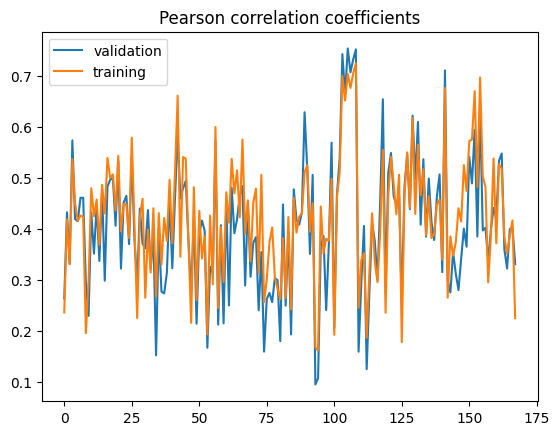

Pearson correlation on training set: 0.4226278358396013
Pearson correlation on validation set: 0.4036178407021704


<Figure size 640x480 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt

n_neurons = spikes_train.shape[1]

pearson_corr_shallowcnn = np.zeros((n_neurons,2))
for i in range(n_neurons):
    pearson_corr_shallowcnn[i,0] = np.corrcoef(spikes_train[:, i],prediction_train[:, i])[0, 1]
    pearson_corr_shallowcnn[i,1] = np.corrcoef(spikes_val[:, i],prediction_val[:, i])[0, 1]
plt.figure()
plt.title('Pearson correlation coefficients')
plt.plot(pearson_corr_shallowcnn[:,1], label='validation')
plt.plot(pearson_corr_shallowcnn[:,0], label='training')
plt.legend()
plt.show()
plt.figure()

print(f"Pearson correlation on training set: {np.mean(pearson_corr_shallowcnn[:,0])}")
print(f"Pearson correlation on validation set: {np.mean(pearson_corr_shallowcnn[:,1])}")

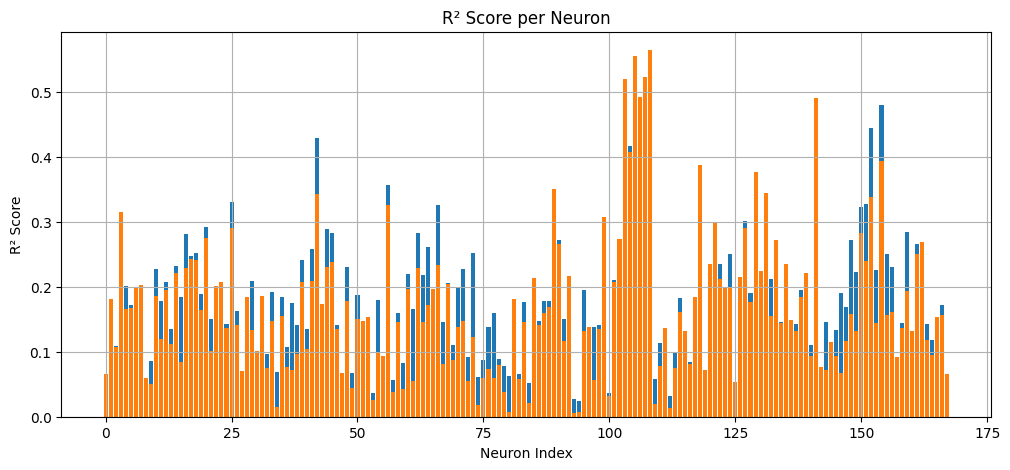

In [24]:
from sklearn.metrics import r2_score

r2_train = [r2_score(spikes_train[:, i], prediction_train[:, i]) for i in range(spikes_train.shape[1])]
r2_val = [r2_score(spikes_val[:, i], prediction_val[:, i]) for i in range(spikes_val.shape[1])]

plt.figure(figsize=(12, 5))
plt.bar(range(len(r2_train)), r2_train)
plt.bar(range(len(r2_val)), r2_val)
plt.xlabel('Neuron Index')
plt.ylabel('R² Score')
plt.title('R² Score per Neuron')
plt.grid(True)
plt.show()

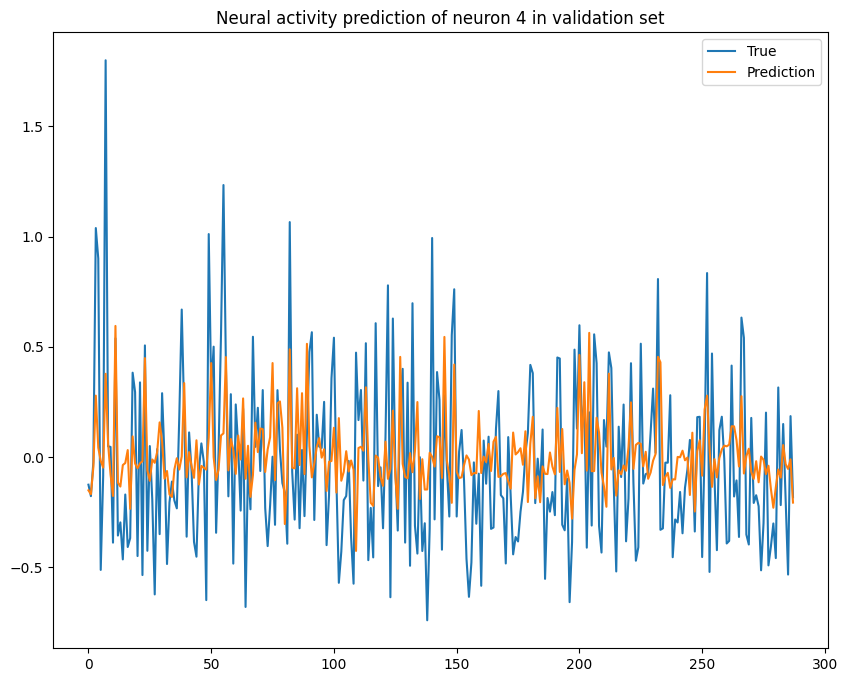

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [25]:
example_id = 4

plt.figure(figsize= (10,8))
plt.title(f'Neural activity prediction of neuron {example_id} in validation set')
plt.plot(spikes_val[:,example_id], label = "True")
plt.plot(prediction_val[:,example_id], label = "Prediction")
plt.legend()
plt.show()
plt.figure()

In [26]:
model.eval()

prediction_test = []

with torch.no_grad():
    for stimulus in ITdataloader_test:
        inputs = stimulus.to(device)
        outputs = model(inputs)
        prediction_test.append(outputs.cpu())

prediction_test = torch.cat(prediction_test, dim=0)
prediction_test.shape

torch.Size([320, 168])

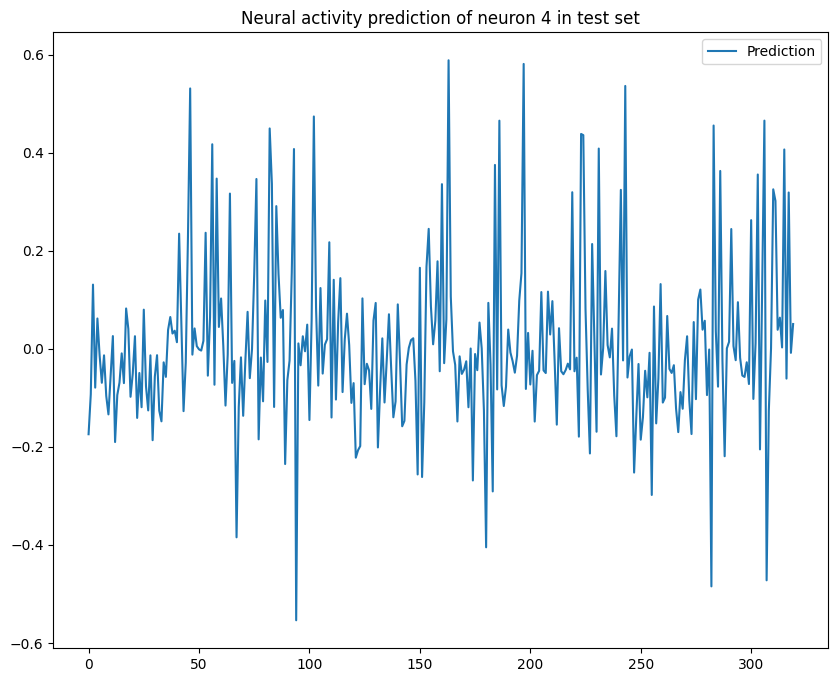

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [27]:
example_id = 4

plt.figure(figsize= (10,8))
plt.title(f'Neural activity prediction of neuron {example_id} in test set')
plt.plot(prediction_test[:,example_id], label = "Prediction")
plt.legend()
plt.show()
plt.figure()